In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import cv2
import random

In [2]:
from google.colab import drive
# drive.mount('/kaggle/input/dataset-redweb/ReDWeb_V1')

In [3]:
file_path = '/kaggle/input/dataset-redweb/ReDWeb_V1'

import os

if os.path.exists(file_path):
    print(f'Extracting {file_path} to /content/...')
    !tar -xzf "{file_path}" -C /content/
    print('Extraction complete.')
else:
    print(f'Error: File not found at {file_path}. Please check the path and try again.')

Extracting /kaggle/input/dataset-redweb/ReDWeb_V1 to /content/...
tar (child): /kaggle/input/dataset-redweb/ReDWeb_V1: Cannot read: Is a directory
tar (child): At beginning of tape, quitting now
tar (child): Error is not recoverable: exiting now

gzip: stdin: unexpected end of file
tar: Child returned status 2
tar: Error is not recoverable: exiting now
Extraction complete.


In [4]:
from pathlib import Path
data_path = Path('/kaggle/input/dataset-redweb/ReDWeb_V1')

In [5]:
os.listdir(data_path)

['RDs', 'Imgs']

## Creating the dataset

In [6]:
from torch.utils.data import Dataset
import cv2

class ReDWebDataset(Dataset):
    def __init__(self, rgb_paths, depth_paths, transform=None):
        self.rgb_paths = rgb_paths
        self.depth_paths = depth_paths
        self.transform = transform

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.rgb_paths[idx])
        depth = cv2.imread(self.depth_paths[idx], cv2.IMREAD_UNCHANGED)

        if self.transform:
            img, depth = self.transform(img, depth)
        return img, depth


In [7]:
filenames = os.listdir(data_path / 'Imgs')

images_filenames = [data_path / 'Imgs' / filename for filename in filenames]
depths_filenames = [data_path / 'RDs' / f"{filename.split('.')[0]}.png" for filename in filenames]

In [8]:
full_dataset = ReDWebDataset(images_filenames, depths_filenames)

## Test/Train/Validation split

- Train: 70% (2520 images)
- Test: 15% (540 images)
- Validation: 15% (540 images)

In [9]:
from sklearn.model_selection import train_test_split

indices = list(range(len(full_dataset)))

train_indices, temp_indices = train_test_split(
    indices, test_size=0.30, random_state=42, shuffle=True
)

val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.50, random_state=42, shuffle=True
)


In [10]:
train_imgs  = [images_filenames[i] for i in train_indices]
train_depth = [depths_filenames[i] for i in train_indices]

val_imgs  = [images_filenames[i] for i in val_indices]
val_depth = [depths_filenames[i] for i in val_indices]

test_imgs  = [images_filenames[i] for i in test_indices]
test_depth = [depths_filenames[i] for i in test_indices]

## Augmenting function


In [11]:
import random
import cv2
import numpy as np
import torch

def train_transform(img, depth):
    if random.random() < 0.5:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        img[:,:,2] = img[:,:,2] * random.uniform(0.9, 1.1)
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    # 50% chance of flip
    if random.random() < 0.5:
        img = cv2.flip(img, 1)
        depth = cv2.flip(depth, 1)

    # Random resized crop
    h, w = img.shape[:2]
    scale = random.uniform(0.8, 1.0)  # keep 80–100% of image
    new_h, new_w = int(scale*h), int(scale*w)
    y = random.randint(0, h-new_h)
    x = random.randint(0, w-new_w)

    img = img[y:y+new_h, x:x+new_w]
    depth = depth[y:y+new_h, x:x+new_w]

    # Resize into 384x384
    img = cv2.resize(img, (384, 384))
    depth = cv2.resize(depth, (384, 384))

    img = torch.from_numpy(img).permute(2,0,1).float() / 255.0
    depth = torch.from_numpy(depth).float() / 255.0

    return img, depth


def val_transform(img, depth):
    img = cv2.resize(img, (384, 384))
    depth = cv2.resize(depth, (384, 384))
    return torch.from_numpy(img).permute(2,0,1)/255.0, torch.from_numpy(depth)/255.0

In [12]:
train_dataset = ReDWebDataset(train_imgs, train_depth, transform=train_transform)
val_dataset   = ReDWebDataset(val_imgs, val_depth, transform=val_transform)
test_dataset  = ReDWebDataset(test_imgs, test_depth, transform=val_transform)

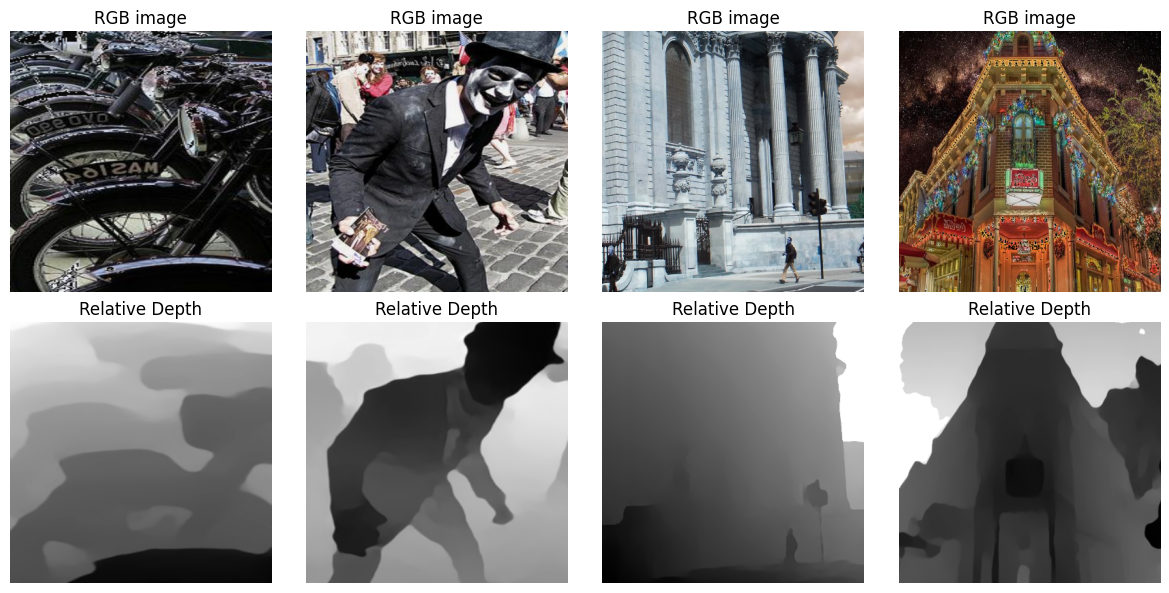

In [13]:
import matplotlib.pyplot as plt

def visualize_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*3, 6))

    for i in range(num_samples):
        idx = random.randint(0, len(dataset)-1)
        img, depth = dataset[idx]  # get sample

        # Convert tensor → numpy for plotting
        if torch.is_tensor(img):
            img_np = img.permute(1,2,0).cpu().numpy()
        else:
            img_np = img[:,:,::-1]  # BGR→RGB if still numpy

        if torch.is_tensor(depth):
            depth_np = depth.squeeze().cpu().numpy()
        else:
            depth_np = depth

        # Show RGB
        axes[0, i].imshow(img_np, cmap=None)
        axes[0, i].set_title("RGB image")
        axes[0, i].axis('off')

        # Show depth
        axes[1, i].imshow(depth_np, cmap="gray")
        axes[1, i].set_title("Relative Depth")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset, num_samples=4)

## EDA


Most common RGB resolutions (width, height):
  484x356: 24 images
  772x572: 10 images
  772x581: 6 images
  484x366: 6 images
  484x371: 5 images

Most common depth resolutions (width, height):
  484x356: 24 depth maps
  772x572: 10 depth maps
  772x581: 6 depth maps
  484x366: 6 depth maps
  484x371: 5 depth maps


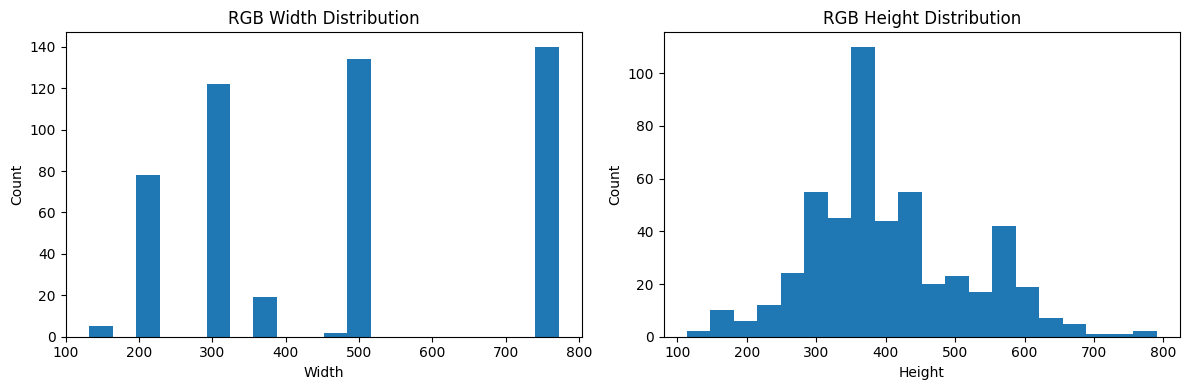

In [14]:
max_samples = min(500, len(full_dataset))
rgb_sizes = []
depth_sizes = []

for i in range(max_samples):
    img_path = images_filenames[i]
    depth_path = depths_filenames[i]

    img = cv2.imread(str(img_path))
    depth = cv2.imread(str(depth_path), cv2.IMREAD_UNCHANGED)

    if img is None or depth is None:
        continue

    rgb_sizes.append((img.shape[1], img.shape[0]))   # w, h
    depth_sizes.append((depth.shape[1], depth.shape[0]))

rgb_counter = Counter(rgb_sizes)
depth_counter = Counter(depth_sizes)

print("\nMost common RGB resolutions (width, height):")
for (w, h), c in rgb_counter.most_common(5):
    print(f"  {w}x{h}: {c} images")

print("\nMost common depth resolutions (width, height):")
for (w, h), c in depth_counter.most_common(5):
    print(f"  {w}x{h}: {c} depth maps")

rgb_widths  = [w for w, h in rgb_sizes]
rgb_heights = [h for w, h in rgb_sizes]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(rgb_widths, bins=20)
plt.title("RGB Width Distribution")
plt.xlabel("Width")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(rgb_heights, bins=20)
plt.title("RGB Height Distribution")
plt.xlabel("Height")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Depth value stats (non-zero):
  Min:  1.0000
  Max:  255.0000
  Mean: 160.5413
  Std:  72.1454


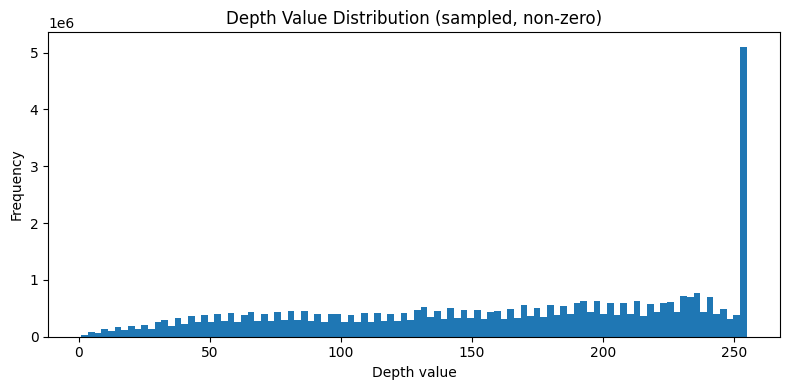

In [15]:
depth_values_sampled = []

max_depth_samples = min(200, len(full_dataset))
for i in range(max_depth_samples):
    depth = cv2.imread(str(depths_filenames[i]), cv2.IMREAD_UNCHANGED)
    if depth is None:
        continue

    vals = depth.flatten()
    vals = vals[vals > 0]
    if vals.size > 0:
        depth_values_sampled.append(vals)

if depth_values_sampled:
    depth_values = np.concatenate(depth_values_sampled)

    print("\nDepth value stats (non-zero):")
    print(f"  Min:  {depth_values.min():.4f}")
    print(f"  Max:  {depth_values.max():.4f}")
    print(f"  Mean: {depth_values.mean():.4f}")
    print(f"  Std:  {depth_values.std():.4f}")

    plt.figure(figsize=(8,4))
    plt.hist(depth_values, bins=100)
    plt.title("Depth Value Distribution (sampled, non-zero)")
    plt.xlabel("Depth value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [16]:
max_rgb_stats_samples = min(200, len(full_dataset))
channel_means = []
channel_stds = []

for i in range(max_rgb_stats_samples):
    img = cv2.imread(str(images_filenames[i]))
    if img is None:
        continue

    img = img.astype(np.float32) / 255.0  # normalize
    b, g, r = cv2.split(img)

    channel_means.append([b.mean(), g.mean(), r.mean()])
    channel_stds.append([b.std(), g.std(), r.std()])

channel_means = np.array(channel_means)
channel_stds = np.array(channel_stds)

print("\nRGB channel mean over dataset (B, G, R):", channel_means.mean(axis=0))
print("RGB channel std over dataset  (B, G, R):", channel_stds.mean(axis=0))



RGB channel mean over dataset (B, G, R): [0.40112686 0.43245274 0.44964454]
RGB channel std over dataset  (B, G, R): [0.2446919  0.23198783 0.23853187]


Per-image depth histograms:


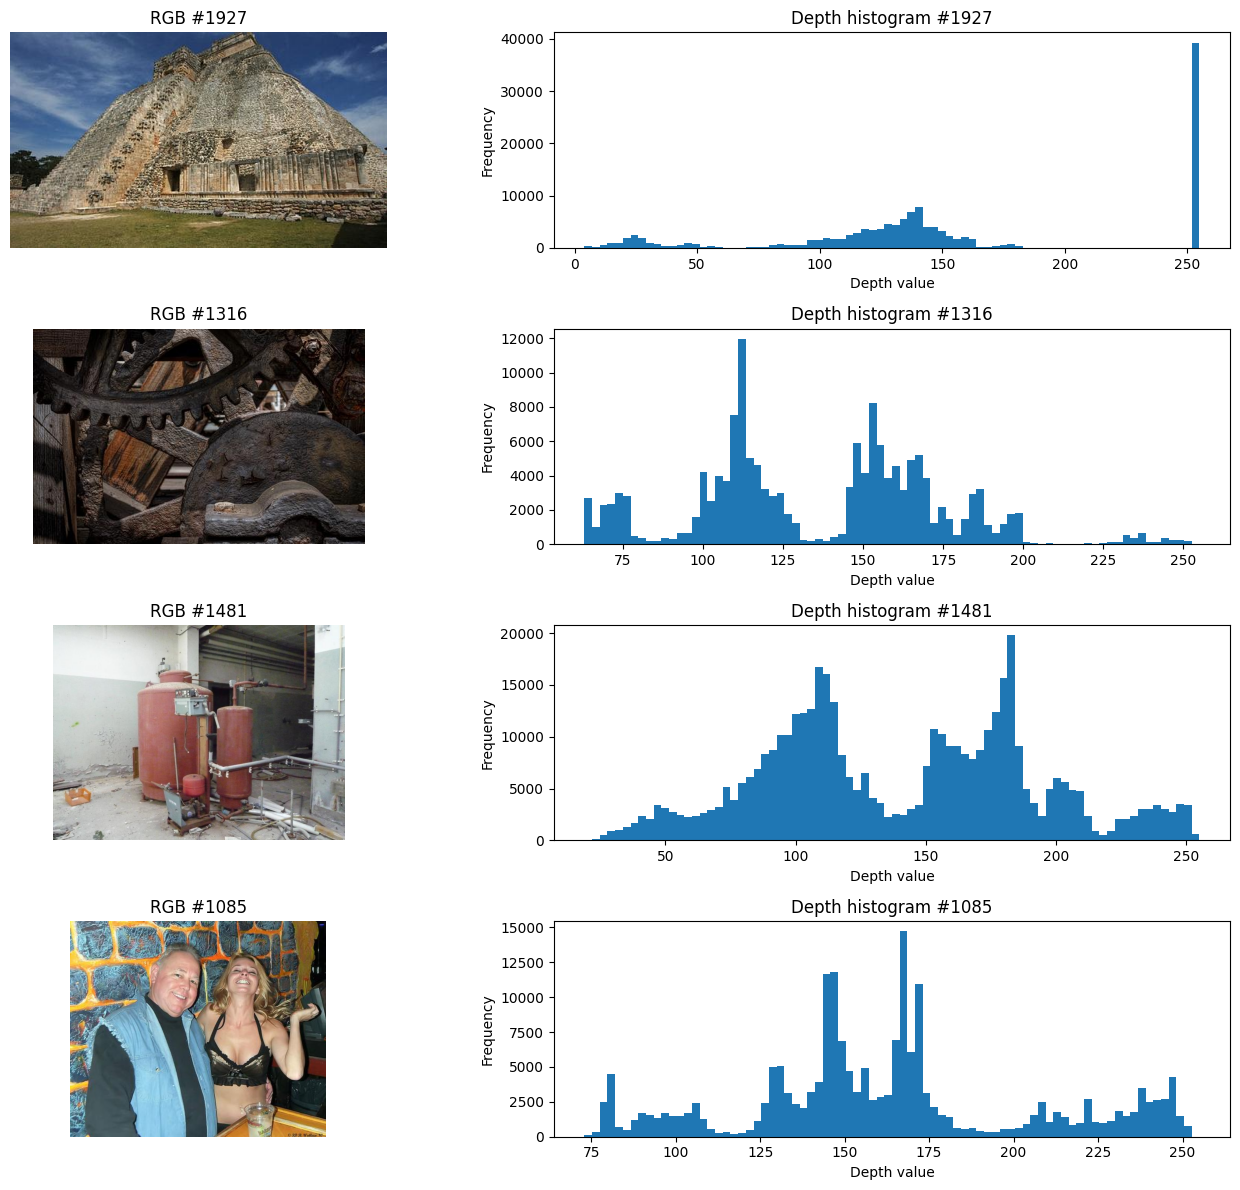

In [17]:
def load_pair(idx):
    img = cv2.imread(str(images_filenames[idx]))
    depth = cv2.imread(str(depths_filenames[idx]), cv2.IMREAD_UNCHANGED)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb, depth
def show_depth_histograms(num_samples=4):
    indices = random.sample(range(len(full_dataset)), num_samples)

    plt.figure(figsize=(14, 3 * num_samples))
    for row, idx in enumerate(indices):
        img_rgb, depth = load_pair(idx)

        vals = depth.flatten()
        vals = vals[vals > 0]

        plt.subplot(num_samples, 2, 2*row + 1)
        plt.imshow(img_rgb)
        plt.title(f"RGB #{idx}")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2*row + 2)
        plt.hist(vals, bins=80)
        plt.title(f"Depth histogram #{idx}")
        plt.xlabel("Depth value")
        plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

print("Per-image depth histograms:")
show_depth_histograms(num_samples=4)

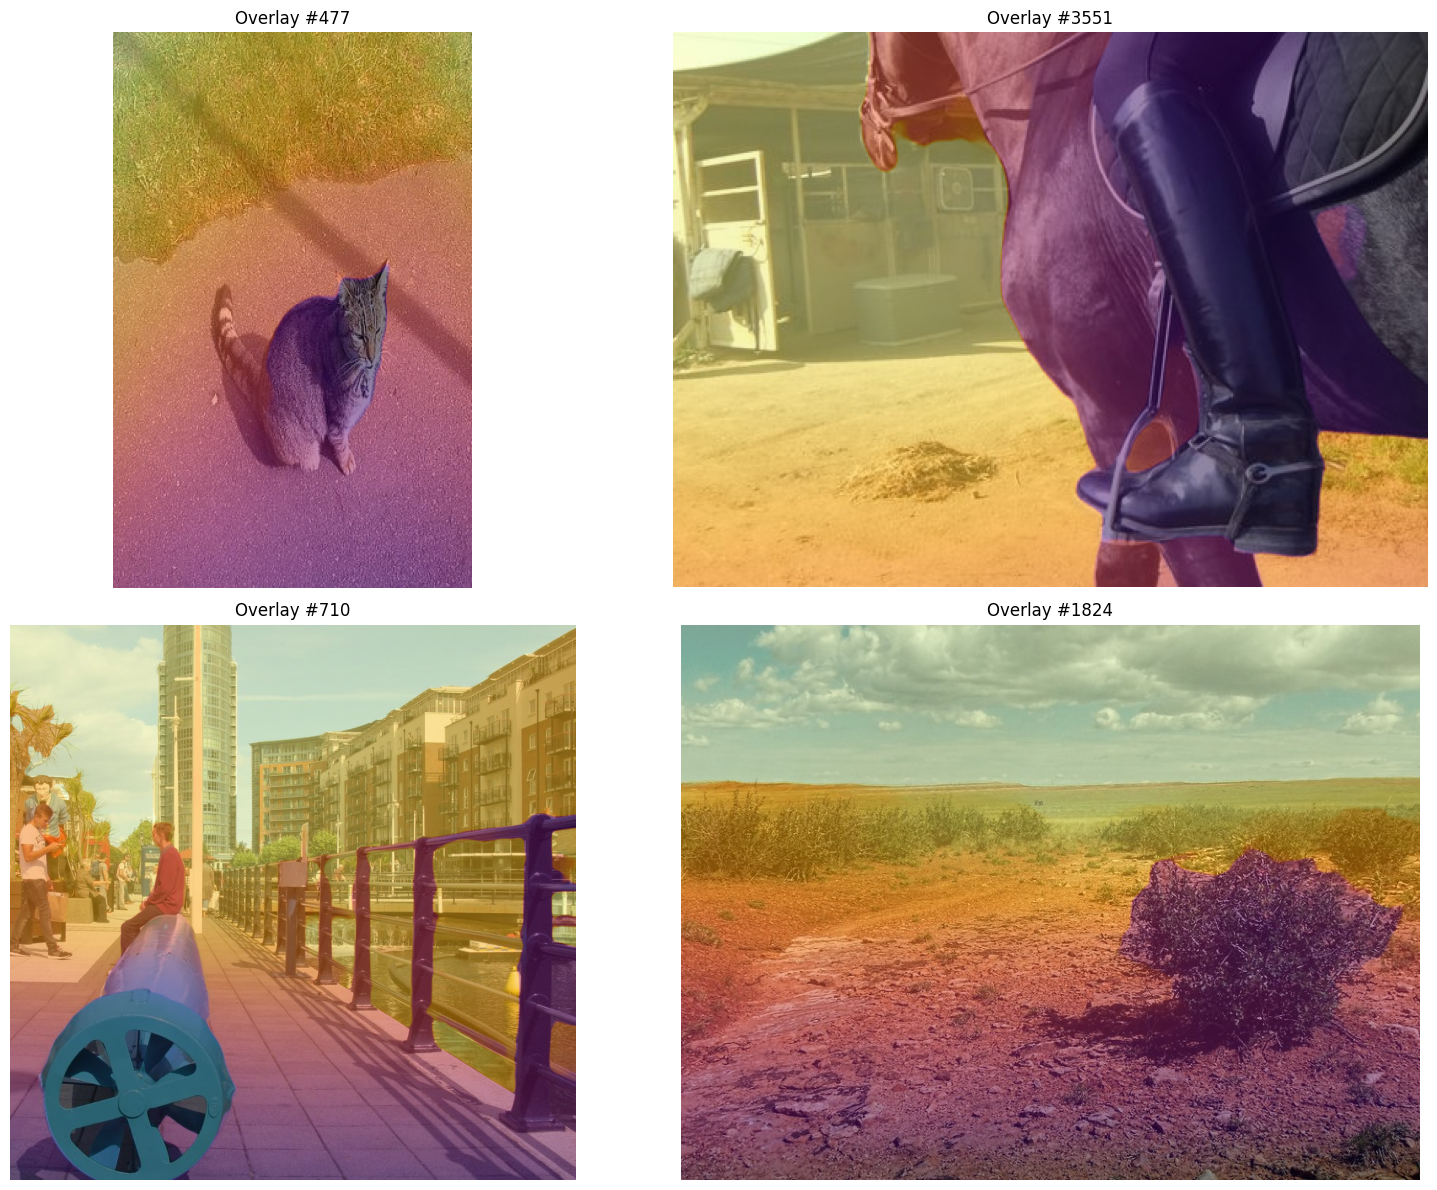

In [18]:
def overlay_depth_grid(num_samples=4, alpha=0.5):
    indices = random.sample(range(len(full_dataset)), num_samples)

    plt.figure(figsize=(16, 12))

    for i, idx in enumerate(indices):
        img_rgb, depth = load_pair(idx)

        # Resize
        if depth.shape[:2] != img_rgb.shape[:2]:
            depth_resized = cv2.resize(
                depth, (img_rgb.shape[1], img_rgb.shape[0]),
                interpolation=cv2.INTER_NEAREST
            )
        else:
            depth_resized = depth

        # Normalize
        depth_norm = depth_resized.astype(np.float32)
        if depth_norm.max() > 0:
            depth_norm /= depth_norm.max()

        plt.subplot(2, 2, i + 1)
        plt.imshow(img_rgb)
        plt.imshow(depth_norm, cmap='inferno', alpha=alpha)
        plt.title(f"Overlay #{idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run it
overlay_depth_grid(num_samples=4, alpha=0.5)


Vertical depth profile example:


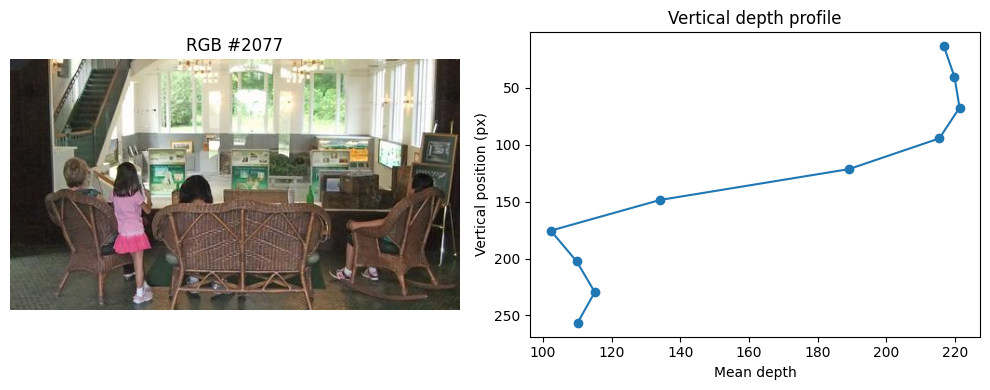

In [19]:
def show_vertical_depth_profile(idx, num_strips=8):
    img_rgb, depth = load_pair(idx)

    # Resize
    if depth.shape[:2] != img_rgb.shape[:2]:
        depth = cv2.resize(depth, (img_rgb.shape[1], img_rgb.shape[0]),
                           interpolation=cv2.INTER_NEAREST)

    h, w = depth.shape[:2]
    strip_height = h // num_strips

    means = []
    ys = []
    for i in range(num_strips):
        y0 = i * strip_height
        y1 = h if i == num_strips - 1 else (i + 1) * strip_height
        strip = depth[y0:y1, :]
        vals = strip.flatten()
        vals = vals[vals > 0]
        if vals.size > 0:
            means.append(vals.mean())
            ys.append((y0 + y1) / 2)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.title(f"RGB #{idx}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.plot(means, ys, marker="o")
    plt.gca().invert_yaxis()
    plt.xlabel("Mean depth")
    plt.ylabel("Vertical position (px)")
    plt.title("Vertical depth profile")
    plt.tight_layout()
    plt.show()

print("Vertical depth profile example:")
show_vertical_depth_profile(random.randint(0, len(full_dataset) - 1), num_strips=10)


Depth edge vs RGB edge example:


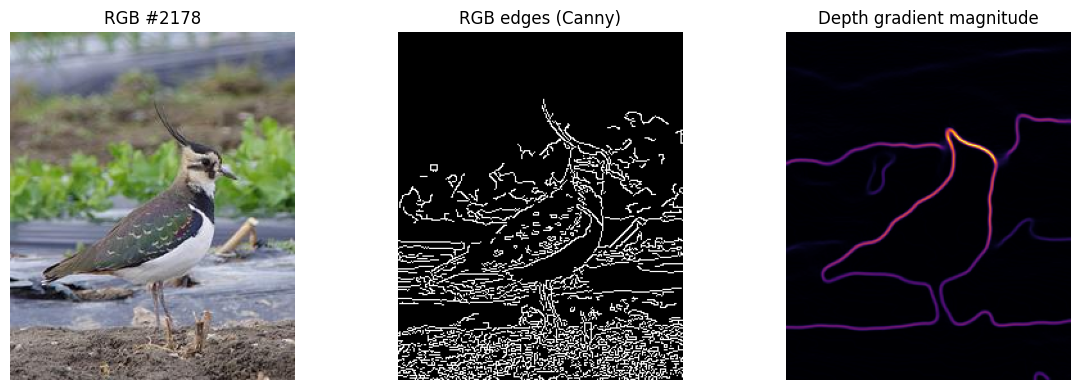

In [20]:
def show_depth_edges(idx):
    img_rgb, depth = load_pair(idx)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    if depth.shape[:2] != gray.shape[:2]:
        depth = cv2.resize(depth, (gray.shape[1], gray.shape[0]),
                           interpolation=cv2.INTER_NEAREST)


    edges_rgb = cv2.Canny(gray, 100, 200)
    depth_float = depth.astype(np.float32)
    depth_float[depth_float <= 0] = 0
    dx = cv2.Sobel(depth_float, cv2.CV_32F, 1, 0, ksize=3)
    dy = cv2.Sobel(depth_float, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(dx**2 + dy**2)

    # Normalize
    if mag.max() > 0:
        mag_vis = (mag / mag.max() * 255).astype(np.uint8)
    else:
        mag_vis = mag.astype(np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img_rgb)
    plt.title(f"RGB #{idx}")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(edges_rgb, cmap="gray")
    plt.title("RGB edges (Canny)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(mag_vis, cmap="inferno")
    plt.title("Depth gradient magnitude")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

print("Depth edge vs RGB edge example:")
show_depth_edges(random.randint(0, len(full_dataset) - 1))


## Model implementation

In [21]:
import torch.nn as nn

def resnet_encoder():
  """
    Load resnext101 and use first 4 pretrained layers as encoder,
    output channels are 256, 512, 1024, 2048 for each layer accordingly
  """

  resnet = torch.hub.load("facebookresearch/WSL-Images", "resnext101_32x8d_wsl")

  pretrained = nn.Module()
  pretrained.layer1 = nn.Sequential(
      resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool, resnet.layer1
  )

  pretrained.layer2 = resnet.layer2
  pretrained.layer3 = resnet.layer3
  pretrained.layer4 = resnet.layer4

  return pretrained

def create_unet_skip_connections(resnet):
  connections = nn.Module()

  connections.layer1_rn = nn.Conv2d(
      256, 256, kernel_size=3, stride=1, padding=1, bias=False, groups=1
  )
  connections.layer2_rn = nn.Conv2d(
      512, 256, kernel_size=3, stride=1, padding=1, bias=False, groups=1
  )
  connections.layer3_rn = nn.Conv2d(
      1024, 256, kernel_size=3, stride=1, padding=1, bias=False, groups=1
  )
  connections.layer4_rn = nn.Conv2d(
      2048, 256, kernel_size=3, stride=1, padding=1, bias=False, groups=1
  )

  return connections

In [22]:

class ResudualConvBlock(nn.Module):
  def __init__(self, features):
    super().__init__()

    self.conv1 = nn.Conv2d(
        features, features, kernel_size=3, stride=1, padding=1, bias=True
    )

    self.conv2 = nn.Conv2d(
        features, features, kernel_size=3, stride=1, padding=1, bias=True
    )

    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    out = self.relu(x)
    out = self.conv1(out)
    out = self.relu(out)
    out = self.conv2(out)

    return out + x

In [23]:
class FeatureFusionBlock(nn.Module):
  def __init__(self, features):
    super(FeatureFusionBlock, self).__init__()

    self.resConfUnit1 = ResudualConvBlock(features)
    self.resConfUnit2 = ResudualConvBlock(features)

  def forward(self, *xs):
    output = xs[0]

    if len(xs) == 2:
        output += self.resConfUnit1(xs[1])

    output = self.resConfUnit2(output)

    output = nn.functional.interpolate(
        output, scale_factor=2, mode="bilinear", align_corners=True
    )

    return output

In [24]:
class Interpolate(nn.Module):
  def __init__(self, scale_factor, mode, align_corners=False):
    super(Interpolate, self).__init__()

    self.interp = nn.functional.interpolate
    self.scale_factor = scale_factor
    self.mode = mode
    self.align_corners = align_corners

  def forward(self, x):
    x = self.interp(
        x, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners
    )

    return x

In [25]:
class DepthEstimationModel(nn.Module):
  def __init__(self):
    super(DepthEstimationModel, self).__init__()

    self.resnet_encoder = resnet_encoder()
    self.skip_connections = create_unet_skip_connections(self.resnet_encoder)

    self.feature_fusion1 = FeatureFusionBlock(256)
    self.feature_fusion2 = FeatureFusionBlock(256)
    self.feature_fusion3 = FeatureFusionBlock(256)
    self.feature_fusion4 = FeatureFusionBlock(256)

    self.adaptive_output = nn.Sequential(
      nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
      Interpolate(scale_factor=2, mode="bilinear"),
      nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(True),
      nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
    )

  def forward(self, x):
    # Encoding part
    encoded_layer_1 = self.resnet_encoder.layer1(x)
    encoded_layer_2 = self.resnet_encoder.layer2(encoded_layer_1)
    encoded_layer_3 = self.resnet_encoder.layer3(encoded_layer_2)
    encoded_layer_4 = self.resnet_encoder.layer4(encoded_layer_3)

    # Skip connections from encoder
    skip1 = self.skip_connections.layer1_rn(encoded_layer_1)
    skip2 = self.skip_connections.layer2_rn(encoded_layer_2)
    skip3 = self.skip_connections.layer3_rn(encoded_layer_3)
    skip4 = self.skip_connections.layer4_rn(encoded_layer_4)

    # Fusing skip connections into the decoder part
    decoded_layer4 = self.feature_fusion4(skip4)
    decoded_layer3 = self.feature_fusion3(skip3, decoded_layer4)
    decoded_layer2 = self.feature_fusion2(skip2, decoded_layer3)
    decoded_layer1 = self.feature_fusion1(skip1, decoded_layer2)
    final_result = self.adaptive_output(decoded_layer1)

    return final_result

In [26]:
model = DepthEstimationModel().cuda()

Downloading: "https://github.com/facebookresearch/WSL-Images/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth


100%|██████████| 340M/340M [00:01<00:00, 311MB/s]


In [27]:
from torchsummary import summary
summary(model, (3, 384,384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           9,408
       BatchNorm2d-2         [-1, 64, 192, 192]             128
              ReLU-3         [-1, 64, 192, 192]               0
         MaxPool2d-4           [-1, 64, 96, 96]               0
            Conv2d-5          [-1, 256, 96, 96]          16,384
       BatchNorm2d-6          [-1, 256, 96, 96]             512
              ReLU-7          [-1, 256, 96, 96]               0
            Conv2d-8          [-1, 256, 96, 96]          18,432
       BatchNorm2d-9          [-1, 256, 96, 96]             512
             ReLU-10          [-1, 256, 96, 96]               0
           Conv2d-11          [-1, 256, 96, 96]          65,536
      BatchNorm2d-12          [-1, 256, 96, 96]             512
           Conv2d-13          [-1, 256, 96, 96]          16,384
      BatchNorm2d-14          [-1, 256,

## Data loaders

In [28]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False
)


In [29]:
import torch
import random

def sample_pairs(depth, num_pairs=2000):
    H = depth.shape[0]
    W = depth.shape[1]
    idx1 = torch.randint(0, H*W, (num_pairs,))
    idx2 = torch.randint(0, H*W, (num_pairs,))
    return idx1, idx2

def ranking_loss(pred, target, margin=0.0, num_pairs=1000):
    B, _, H, W = pred.shape

    pred_flat   = pred.view(B, -1)
    target_flat = target.view(B, -1)

    total_loss = 0.0

    for b in range(B):
        idx1, idx2 = sample_pairs(target[b], num_pairs)

        unequal_pairs_loss = []

        for point1, point2 in zip(idx1, idx2):
            # Ground truth
            g_i = target_flat[b][point1]
            g_j = target_flat[b][point2]

            sigma = 0.02

            l_k = 0
            if g_i / g_j > 1 + sigma:
                l_k = 1
            elif g_j / g_i > 1 + sigma:
                l_k = -1
            else:
                pass # l_k is 0 by defualt

            # Predicted depth
            p1 = pred_flat[b][point1]
            p2 = pred_flat[b][point2]

            loss = 0
            if l_k == 0: # two points have reletivly the same depth
                loss = (p1 - p2)**2
                total_loss += loss
            else:
                loss = torch.log(1 + torch.exp((p2 - p1) * l_k))
                unequal_pairs_loss.append(loss)

        # exclude least 25% of unequal pairs loss
        unequal_pairs_loss.sort()
        bottom_25 = int(len(unequal_pairs_loss) * .25)
        unequal_pairs_loss = unequal_pairs_loss[bottom_25:]

        total_loss += sum(unequal_pairs_loss)

    return total_loss

In [30]:
for img, depth in test_loader:      # ← your DataLoader
    img = img.cuda()

    with torch.no_grad():
        pred = model(img).cpu()     # (B,1,H,W)
        a = ranking_loss(pred, depth)

        print(a)
    break

tensor(3761.5872)


In [31]:
model = DepthEstimationModel().cuda()

# criterion = nn.L1Loss()
criterion = ranking_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main


In [32]:
from tqdm import tqdm

num_epochs = 7

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for img, depth in pbar:

        img = img.cuda()
        depth = depth.cuda()

        optimizer.zero_grad()
        pred = model(img)             # forward pass
        loss = criterion(pred, depth) # compute loss
        loss.backward()               # backprop
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # --- VALIDATION ---
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for img, depth in val_loader:
            img = img.cuda()
            depth = depth.cuda()
            pred = model(img)
            val_loss += criterion(pred, depth).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/7: 100%|██████████| 630/630 [31:44<00:00,  3.02s/it]


Epoch 1/7 | Train Loss: 1682.0791 | Val Loss: 1515.0409


Epoch 2/7: 100%|██████████| 630/630 [31:57<00:00,  3.04s/it]


Epoch 2/7 | Train Loss: 1590.5203 | Val Loss: 1511.4130


Epoch 3/7: 100%|██████████| 630/630 [31:58<00:00,  3.05s/it]


Epoch 3/7 | Train Loss: 1547.6383 | Val Loss: 1507.8587


Epoch 4/7: 100%|██████████| 630/630 [31:56<00:00,  3.04s/it]


Epoch 4/7 | Train Loss: 1513.9415 | Val Loss: 1431.0780


Epoch 5/7: 100%|██████████| 630/630 [31:57<00:00,  3.04s/it]


Epoch 5/7 | Train Loss: 1467.9698 | Val Loss: 1442.8243


Epoch 6/7: 100%|██████████| 630/630 [31:57<00:00,  3.04s/it]


Epoch 6/7 | Train Loss: 1433.7750 | Val Loss: 1434.2833


Epoch 7/7: 100%|██████████| 630/630 [32:22<00:00,  3.08s/it]


Epoch 7/7 | Train Loss: 1412.5344 | Val Loss: 1434.8410


In [33]:
# To save model with optimizer
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, "checkpoint.pth")

In [34]:
# To laod the model
checkpoint = torch.load("checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.ranking_loss was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.ranking_loss])` or the `torch.serialization.safe_globals([__main__.ranking_loss])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
for img, depth in test_loader:      # ← your DataLoader
    img = img.cuda()

    with torch.no_grad():
        pred = model(img).cpu()     # (B,1,H,W)
        # print(pred.shape)
        # ranking_loss(pred, depth)

    # visualize first 4 samples in batch
    for i in range(4):
        image_np = img[i].permute(1,2,0).cpu().numpy()        # (H,W,3)
        depth_np = depth[i].squeeze().cpu().numpy()           # (H,W)
        pred_np  = pred[i].squeeze().numpy()                  # (H,W)

        plt.figure(figsize=(10,3))

        plt.subplot(1,3,1)
        plt.title("Image")
        plt.imshow(image_np)
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.title("Ground Truth Depth")
        plt.imshow(depth_np, cmap='inferno')
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.title("Prediction")
        plt.imshow(pred_np, cmap='inferno')
        plt.axis("off")

        plt.show()

    break

In [ ]:
img, depth = full_dataset[0]

depth[0][0] / depth [100][100]

In [ ]:
depth